<a href="https://colab.research.google.com/github/Arthur-ca/MIE1517/blob/YayunYang/Project_small.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import torch
import numpy as np
import os
import random
import torchvision
import time
import cv2 as cv
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as F1
import matplotlib.pyplot as plt
import torch.optim as optim
import imgaug.augmenters as iaa
from sklearn.model_selection import train_test_split
from torchvision import datasets, models, transforms
from collections import defaultdict
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision.datasets import ImageFolder
from collections import Counter

In [ ]:
directory_path = '/content/gdrive/MyDrive/archive'
ds_store_path = os.path.join(directory_path, '.DS_Store')

if os.path.exists(ds_store_path):
    os.remove(ds_store_path)
else:
    print(".DS_Store file does not exist in the directory.")

In [9]:
#First link it to google drive and check the subfolder of the data
# data_path = '/home/qinghao/backup/MIE1517/dataset'
data_path = 'C:/Users/Z/Desktop/MIE1517/data'
drive_content = os.listdir(data_path)
print(drive_content)

['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutrality', 'sadness', 'surprise']


In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [10]:
classeses = []
for i in os.listdir(data_path):
    if i!=5:
        classeses.append(i)
classeses

['anger',
 'contempt',
 'disgust',
 'fear',
 'happiness',
 'neutrality',
 'sadness',
 'surprise']

In [6]:
# def gauss_noise_tensor(img):
#     assert isinstance(img, torch.Tensor)
#     dtype = img.dtype
#     if not img.is_floating_point():
#         img = img.to(torch.float32)

#     sigma = 25.0

#     out = img + sigma * torch.randn_like(img)

#     if out.dtype != dtype:
#         out = out.to(dtype)

#     return out
# class ImgAugTransform:
#     def __init__(self):
#         self.aug = iaa.Sequential([
#             iaa.Resize({"height": 224, "width": 224}),
#             iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))),
#             iaa.Sometimes(0.25, iaa.Affine(rotate=(-20, 20), mode='symmetric')),
#             iaa.Sometimes(0.25, iaa.OneOf([
#                 iaa.Dropout(p=(0, 0.1)),
#                 iaa.CoarseDropout(0.1, size_percent=0.5)
#             ])),
#             iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)
#         ])

#     def __call__(self, img):
#         img = np.array(img)

#         augmented_img = self.aug.augment_image(img)

#         # Convert the augmented image to PyTorch tensor
#         augmented_tensor = F1.to_tensor(augmented_img)
#         return self.aug.augment_image(img)
#   imgaug_transform = ImgAugTransform()

```
Our dataset contains over 5000 photos. Training on this dataset requires significant computing power. However, the best hardware we have is a computer equipped with an Nvidia RTX2080 GPU. To ensure that the model can be trained on the entire dataset, we plan to use 5% of the original data as our training dataset. Below is our code for extracting a small training dataset, a small training function, and the CNN model structure.
```

In [7]:
features_or = []
labels_or = []
train_data_or = []
data_transform1 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
def create_train2(data_percentage=5):
    for i, photo in enumerate(classeses):
        path = os.path.join(data_path, photo)
        label = i  # Use the index of the class as the label

        # List all images in the class folder
        img_list = os.listdir(path)

        # Calculate the number of images to load (5% of total)
        num_images_to_load = int(len(img_list) * (data_percentage / 100))

        # Randomly select a subset of images
        selected_images = random.sample(img_list, num_images_to_load)


        for img_name in selected_images:
            img_path = os.path.join(path, img_name)
            img_pil = Image.open(img_path)
            transformed_image1 = data_transform1(img_pil)

            if img_pil is None:
                print("Error loading image:", img_path)
                continue

            # Append the original image and its label to the list
            features_or.append(transformed_image1)
            labels_or.append(label)

            train_data_or.append([img_pil, label])

create_train2(data_percentage=5)  # Load only 5% of the data
print(type(features_or[0]))
# Count the occurrences of each label
label_counts_or = Counter(labels_or)

# Print the label counts
for label, count in label_counts_or.items():
    print(f"Label {label}: {count} images")


<class 'torch.Tensor'>
Label 0: 37 images
Label 1: 10 images
Label 2: 21 images
Label 3: 26 images
Label 4: 28 images
Label 5: 70 images
Label 6: 38 images
Label 7: 44 images


In [8]:
# Define a transformation to convert PIL images to PyTorch tensors
data_transform_to_tensor = transforms.Compose([
    transforms.ToTensor()
])

# Convert images and labels to PyTorch tensors
train_images = torch.stack([data_transform_to_tensor(data[0]) for data in train_data_or])
train_labels = torch.tensor([data[1] for data in train_data_or])

# Assuming you have a DataLoader for your training loop
train_dataset = torch.utils.data.TensorDataset(train_images, train_labels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

In [9]:
def get_accuracy(model, dataset):
    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(dataset, batch_size=64):
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [10]:
def trainSmall(model, data, batch_size, learning_rate, num_epochs):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_acc = []

    # training
    print("Training Start")
    n = 0  # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            #############################################
            # To Enable GPU Usage
            imgs = imgs.cuda()
            labels = labels.cuda()
            #############################################

            # Check if imgs is already a tensor
            if not torch.is_tensor(imgs):
                img_to_tensor = transforms.ToTensor()
                imgs = img_to_tensor(imgs)

                # Convert input to float
                imgs = imgs.float()

            # Convert the input tensor to the desired type
            imgs = imgs.type(torch.float32)

            out = model(imgs)  # forward pass
            loss = criterion(out, labels)  # compute the total loss
            loss.backward()  # backward pass (compute parameter updates)
            optimizer.step()  # make the updates for each parameter
            optimizer.zero_grad()  # a clean-up step for PyTorch
            n += 1

        train_accuracy = get_accuracy(model, data)
        train_acc.append(train_accuracy)
        print("Epoch:{}, Accuracy:{}".format(epoch, train_accuracy))
    return train_acc

In [11]:
class CNNLargeNet2(nn.Module):
    def __init__(self):
        super(CNNLargeNet2, self).__init__()
        self.name = "CNN"

        # Define the sequential layers for feature extraction
        self.features = nn.Sequential(
            # Convolutional Layer 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Convolutional Layer 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Convolutional Layer 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Convolutional Layer 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Convolutional Layer 5
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        # Flatten the tensor for the fully connected layers
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 1024),
            nn.ReLU(inplace=True),
            #nn.Dropout(p=0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            #nn.Dropout(p=0.5),
            nn.Linear(512, 8)
        )

    def forward(self, x):
        x = self.features(x)  # Pass the input through the feature layers
        x = x.view(x.size(0), -1)  # Flatten the tensor for the classifier
        x = self.classifier(x)  # Pass the flattened tensor through the classifier
        return x


Below is the process by which we tuned the hyperparameters and trained the model to achieve overfitting. During this process we tried many different combinations of hyperparameters, and only a few examples are shown below along with their results. In the end, we reached overfitting after 260 epochs with batch_size = 64 and learning_rate = 0.005.

In [14]:
use_cuda = True
if torch.cuda.is_available():
    model = CNNLargeNet2().cuda()
Y = trainSmall(model, train_dataset, batch_size=128, learning_rate=0.01, num_epochs=500)

Training Start
Epoch:0, Accuracy:0.07664233576642336
Epoch:1, Accuracy:0.2591240875912409
Epoch:2, Accuracy:0.16058394160583941
Epoch:3, Accuracy:0.1678832116788321
Epoch:4, Accuracy:0.1678832116788321
Epoch:5, Accuracy:0.16058394160583941
Epoch:6, Accuracy:0.1678832116788321
Epoch:7, Accuracy:0.17883211678832117
Epoch:8, Accuracy:0.17883211678832117
Epoch:9, Accuracy:0.18248175182481752
Epoch:10, Accuracy:0.17883211678832117
Epoch:11, Accuracy:0.17883211678832117
Epoch:12, Accuracy:0.19708029197080293
Epoch:13, Accuracy:0.18613138686131386
Epoch:14, Accuracy:0.17883211678832117
Epoch:15, Accuracy:0.1678832116788321
Epoch:16, Accuracy:0.17153284671532848
Epoch:17, Accuracy:0.19343065693430658
Epoch:18, Accuracy:0.1897810218978102
Epoch:19, Accuracy:0.18248175182481752
Epoch:20, Accuracy:0.18613138686131386
Epoch:21, Accuracy:0.20072992700729927
Epoch:22, Accuracy:0.20437956204379562
Epoch:23, Accuracy:0.20437956204379562
Epoch:24, Accuracy:0.20802919708029197
Epoch:25, Accuracy:0.21532

In [12]:
use_cuda = True
if torch.cuda.is_available():
    model = CNNLargeNet2().cuda()
Y = trainSmall(model, train_dataset, batch_size=64, learning_rate=0.01, num_epochs=500)

Training Start
Epoch:0, Accuracy:0.16058394160583941
Epoch:1, Accuracy:0.0948905109489051
Epoch:2, Accuracy:0.16058394160583941
Epoch:3, Accuracy:0.16423357664233576
Epoch:4, Accuracy:0.15328467153284672
Epoch:5, Accuracy:0.18613138686131386
Epoch:6, Accuracy:0.1897810218978102
Epoch:7, Accuracy:0.18248175182481752
Epoch:8, Accuracy:0.17883211678832117
Epoch:9, Accuracy:0.17883211678832117
Epoch:10, Accuracy:0.18613138686131386
Epoch:11, Accuracy:0.18613138686131386
Epoch:12, Accuracy:0.18613138686131386
Epoch:13, Accuracy:0.20072992700729927
Epoch:14, Accuracy:0.20072992700729927
Epoch:15, Accuracy:0.19343065693430658
Epoch:16, Accuracy:0.20437956204379562
Epoch:17, Accuracy:0.21532846715328466
Epoch:18, Accuracy:0.2116788321167883
Epoch:19, Accuracy:0.20802919708029197
Epoch:20, Accuracy:0.21897810218978103
Epoch:21, Accuracy:0.20072992700729927
Epoch:22, Accuracy:0.22627737226277372
Epoch:23, Accuracy:0.30656934306569344
Epoch:24, Accuracy:0.2664233576642336
Epoch:25, Accuracy:0.339

In [13]:
use_cuda = True
if torch.cuda.is_available():
    model = CNNLargeNet2().cuda()
Y = trainSmall(model, train_dataset, batch_size=64, learning_rate=0.005, num_epochs=260)

Training Start
Epoch:0, Accuracy:0.16058394160583941
Epoch:1, Accuracy:0.0948905109489051
Epoch:2, Accuracy:0.16058394160583941
Epoch:3, Accuracy:0.17518248175182483
Epoch:4, Accuracy:0.18613138686131386
Epoch:5, Accuracy:0.17518248175182483
Epoch:6, Accuracy:0.18613138686131386
Epoch:7, Accuracy:0.18613138686131386
Epoch:8, Accuracy:0.1897810218978102
Epoch:9, Accuracy:0.20437956204379562
Epoch:10, Accuracy:0.20437956204379562
Epoch:11, Accuracy:0.20802919708029197
Epoch:12, Accuracy:0.20802919708029197
Epoch:13, Accuracy:0.20437956204379562
Epoch:14, Accuracy:0.21897810218978103
Epoch:15, Accuracy:0.22992700729927007
Epoch:16, Accuracy:0.23722627737226276
Epoch:17, Accuracy:0.2518248175182482
Epoch:18, Accuracy:0.24817518248175183
Epoch:19, Accuracy:0.27007299270072993
Epoch:20, Accuracy:0.2664233576642336
Epoch:21, Accuracy:0.2591240875912409
Epoch:22, Accuracy:0.24817518248175183
Epoch:23, Accuracy:0.24452554744525548
Epoch:24, Accuracy:0.2591240875912409
Epoch:25, Accuracy:0.20437

```
In the last adjustment of hyperparameters, our training results showed overfitting. This indicates that our model is ready for the next step of training. In the following code, we rewrote the data loader and training function, and added checkpoints for each epoch. We attempted to use 60% of the entire dataset as training data, 20% as validation data, and the remaining 20% as test data.
```

In [11]:
features_or = []
labels_or = []
train_data_or = []
data_transform1 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
def create_train2():
    for i, photo in enumerate(classeses):
        path = os.path.join('C:/Users/Z/Desktop/MIE1517/data', photo)
        label = i  # Use the index of the class as the label

        # Loop over to get every image in the current class
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img_pil = cv.imread(img_path)
            img_pil = Image.fromarray(cv.cvtColor(img_pil, cv.COLOR_BGR2RGB))
            transformed_image1 = data_transform1(img_pil)

            if img_pil is None:
                print("Error loading image:", img_pil)
                continue
            # Append the original image and its label to the list
            features_or.append(transformed_image1)
            labels_or.append(label)

            train_data_or.append([img_pil, label])
create_train2()
print(type(features_or[0]))
# Count the occurrences of each label
label_counts_or = Counter(labels_or)

# Print the label counts
for label, count in label_counts_or.items():
    print(f"Label {label}: {count} images")

<class 'torch.Tensor'>
Label 0: 890 images
Label 1: 208 images
Label 2: 439 images
Label 3: 570 images
Label 4: 1406 images
Label 5: 524 images
Label 6: 746 images
Label 7: 775 images


In [12]:
labels = labels_or
features = features_or
# Shuffle the labels and features in the same order
combined = list(zip(labels, features))
labels, features = zip(*combined)

# Create a dictionary to store images by label
label_to_images = defaultdict(list)

# Group images by label
for label, img in zip(labels, features):
    label_to_images[label].append(img)

# Set the ratios for train, validation, and test sets
train_ratio = 0.6
validation_ratio = 0.2
test_ratio = 0.2

train_data = []
validation_data = []
test_data = []

# Split data for each label
for label, images in label_to_images.items():
    random.shuffle(images)  # Shuffle the images for each label

    num_images = len(images)
    num_train = int(train_ratio * num_images)
    num_validation = int(validation_ratio * num_images)
    num_test = num_images - num_train - num_validation

    train_data.extend([(img, label) for img in images[:num_train]])
    validation_data.extend([(img, label) for img in images[num_train:num_train + num_validation]])
    test_data.extend([(img, label) for img in images[num_train + num_validation:]])

In [13]:
class CNNLargeNet(nn.Module):
    def __init__( self, output1=32, output2=64, output3=128, output4=256):
        super(CNNLargeNet, self).__init__()
        self.name = "CNN"
        
        # Define the sequential layers for feature extraction
        self.features = nn.Sequential(
            # Convolutional Layer 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Convolutional Layer 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Convolutional Layer 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Convolutional Layer 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Convolutional Layer 5
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        # Flatten the tensor for the fully connected layers
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 8)
        )

    def forward(self, x):
        x = self.features(x)  # Pass the input through the feature layers
        x = x.view(x.size(0), -1)  # Flatten the tensor for the classifier
        x = self.classifier(x)  # Pass the flattened tensor through the classifier
        return x

In [14]:
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, learning_rate, epoch)
    return path

def evaluate(model, loader):
    """ Evaluate the network """
    correct = 0
    total = 0

    for inputs, labels in loader:
      if use_cuda and torch.cuda.is_available():
        inputs = inputs.cuda()
        labels = labels.cuda()

      outputs = model(inputs)
      predicted = outputs.max(1, keepdim=True)[1]
      total += inputs.shape[0]
      correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return correct / total

In [15]:
def trainmodel(model, train_dataset, val_dataset, batch=64, learningRate=0.01, num_epochs=300):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learningRate)
    
    model_checkpoint_path = 'D:/MIE1517/output'  # You can change the directory as needed

    train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False) 

    train_accuracy = np.zeros(num_epochs)
    train_losses = np.zeros(num_epochs)
    validation_accuracy = np.zeros(num_epochs)
    validation_losses = np.zeros(num_epochs)
    iters = []

    # Check CUDA availability
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        model = model.cuda()

    n = 0  # Initialize the iteration counter
    # Training
    print("Training Begin...\n")
    start_time = time.time()
    for epoch in range(num_epochs):
        # Train mode
        model.train()  # Set the model to training mode
        running_loss = 0.0
        
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            # Set up for gpu running
            if use_cuda and torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            n += 1
            # Calculate loss
            running_loss += loss.item()

        train_losses[epoch] = running_loss
        train_accuracy[epoch] = evaluate(model, train_loader)
        
        # Evaluation mode
        model.eval()  # Set the model to evaluation mode for accuracy computation
        valid_loss = 0.0
        # Running without gradients are computed and model weights update
        for inputs, labels in val_loader:
            if use_cuda and torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

        validation_losses[epoch] = valid_loss
        validation_accuracy[epoch] = evaluate(model, val_loader)
        iters.append(n)
        
        # Print progress for the epoch
        print(("Epoch {}: Train Accuracy: {}, Train loss: {} |"+
               "Validation Accuracy: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_accuracy[epoch],
                   train_losses[epoch],
                   validation_accuracy[epoch],
                   validation_losses[epoch]))

        # Save model checkpoint every 5 epochs
        # if (epoch + 1) % 5 == 0:  # +1 because epochs start from 0
            # Save the current model checkpoint to a file
        model_path = get_model_name(model.name, batch, learningRate, epoch)
        model_path = os.path.join(model_checkpoint_path, model_path)
        torch.save(model.state_dict(), "{}.pt".format(model_path))

    print("Finshied Training")
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    # Save model checkpoint
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_acc.csv".format(model_checkpoint_path), train_accuracy)
    np.savetxt("{}_train_loss.csv".format(model_checkpoint_path), train_losses)
    np.savetxt("{}_val_acc.csv".format(model_checkpoint_path), validation_accuracy)
    np.savetxt("{}_val_loss.csv".format(model_checkpoint_path), validation_losses)

    plt.title("Training Loss Curve")
    plt.plot(iters, train_losses, label="Train")
    plt.xlabel("iters")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Accuracy Curve")
    plt.plot(iters, train_accuracy, label="Train")
    plt.xlabel("iters")
    plt.ylabel("Accuracy")
    plt.show()
    print("Finished Training")
    return iters, train_losses, train_accuracy, validation_accuracy

Training Begin...

Epoch 1: Train Accuracy: 0.24669867947178872, Train loss: 485.4797168970108 |Validation Accuracy: 0.2587917042380523, Validation loss: 35.40146100521088
Epoch 2: Train Accuracy: 0.25540216086434575, Train loss: 106.2787618637085 |Validation Accuracy: 0.2551848512173129, Validation loss: 35.74875247478485
Epoch 3: Train Accuracy: 0.24429771908763506, Train loss: 106.01051235198975 |Validation Accuracy: 0.23715058611361586, Validation loss: 35.52350211143494
Epoch 4: Train Accuracy: 0.2530012004801921, Train loss: 104.76455867290497 |Validation Accuracy: 0.2533814247069432, Validation loss: 35.40428078174591
Epoch 5: Train Accuracy: 0.2530012004801921, Train loss: 104.6904878616333 |Validation Accuracy: 0.2533814247069432, Validation loss: 35.248910546302795
Epoch 6: Train Accuracy: 0.2530012004801921, Train loss: 103.96354961395264 |Validation Accuracy: 0.2533814247069432, Validation loss: 35.33258938789368
Epoch 7: Train Accuracy: 0.2530012004801921, Train loss: 104.

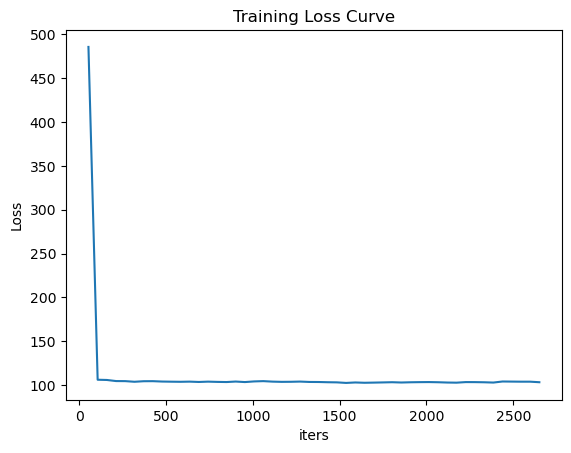

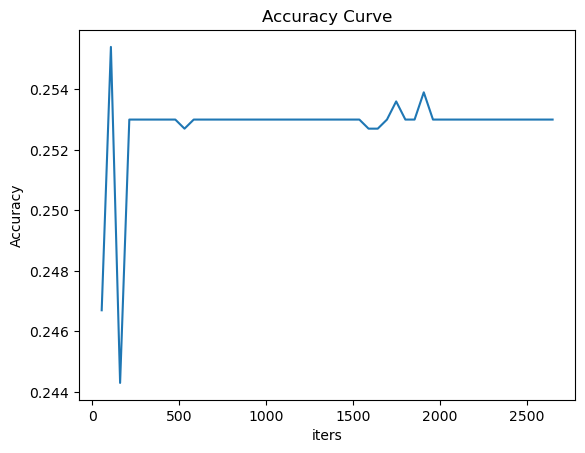

Finished Training


In [17]:
use_cuda = True
if torch.cuda.is_available():
    model = CNNLargeNet().cuda()
Y = trainmodel(model, train_data, validation_data, batch=64, learningRate=0.005, num_epochs=50)

In [ ]:
use_cuda = True
if torch.cuda.is_available():
    model = CNNLargeNet().cuda()
Y = trainmodel(model, train_data, validation_data, batch=64, learningRate=0.001, num_epochs=520)